<a href="https://colab.research.google.com/github/Vidi005/COVID-19-Prediction-Indonesia/blob/master/COVID_19_Prediciton_Indonesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediksi Kasus Penyebaran COVID-19 di Indonesia**

## Import Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

## Mengambil Dataset

Catatan: Dataset kasus COVID-19 di Indonesia yang digunakan terakhir diupdate pada 10 Mei 2020 dalam format "*.csv".
<br>
Sumber dataset : https://data.humdata.org/dataset/indonesia-covid-19-cases-recoveries-and-deaths-per-province

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/COVID-19-Prediction-Indonesia/trunk/datasets > /dev/null

## Mengubah *Caption* tiap Baris Tabel

In [0]:
data=pd.read_csv("datasets/Daily-Update IDN-COVID19 - Sheet5.csv")
data=data.rename(columns={"Date": "Tanggal",                                                     
                          "New_case_per_day": "Terkonfirmasi",
                          "Death_cases_perDay": "Meninggal",
                          "Recovered-cases_perDay": "Sembuh",
                          "Recovered_cases": "Jumlah Sembuh",
                          "Total_death": "Jumlah Meninggal",
                          "Cumulative_cases": "Jumlah Kasus"})

## Memvisualisasikan Data pada Grafik

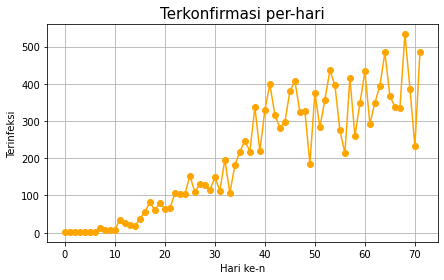

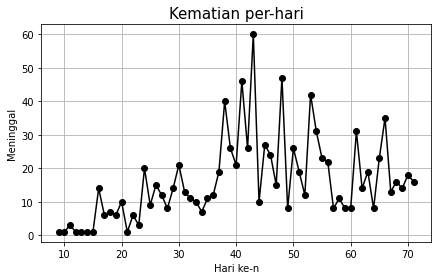

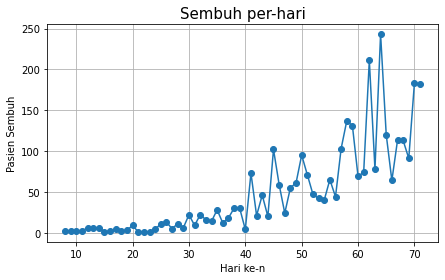

In [4]:
plt.figure(figsize=(7,4))
plt.plot(data.aggregate("Terkonfirmasi",axis=0), marker="o", color="orange")
plt.xlabel("Hari ke-n")
plt.ylabel("Terinfeksi")
plt.title("Terkonfirmasi per-hari", size=15)
plt.grid(zorder = 0)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(data.aggregate("Meninggal",axis=0), marker="o", color="black")
plt.xlabel("Hari ke-n")
plt.ylabel("Meninggal")
plt.title("Kematian per-hari", size=15)
plt.grid(zorder = 0)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(data.aggregate("Sembuh",axis=0), marker='o')
plt.xlabel("Hari ke-n")
plt.ylabel("Pasien Sembuh")
plt.title("Sembuh per-hari", size=15)
plt.grid(zorder = 0)
plt.show()

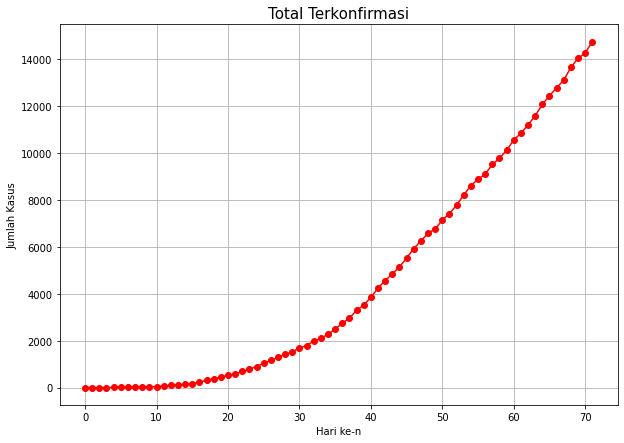

In [5]:
plt.figure(figsize=(10,7))
plt.plot(data.aggregate("Jumlah Kasus",axis=0), marker="o", color="red")
plt.xlabel("Hari ke-n")
plt.ylabel("Jumlah Kasus")
plt.title("Total Terkonfirmasi", size=15)
plt.grid(zorder = 0)
plt.show()

## Memprediksi Jumlah Kasus dengan *Logistic Distribution*

In [0]:
def plot_predict(case, future_days):
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))

    inception = 0    
    graph = data.groupby("Tanggal")[["Jumlah Kasus", "Jumlah Meninggal", "Jumlah Sembuh"]].sum().reset_index()[inception:]
    y = graph[case]
    x = np.arange(len(y))

    # fitting the data on the logistic function
    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method="dogbox", bounds=([12., 0.001, y.mean()],[90., 2.5, 10*y.max()]))
    print(popt_sig)
    peakday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=int(popt_sig[0])), "%Y-%m-%d")
    plt.figure(figsize=(14,7))

    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)

    print("Prediksi:")
    for i in range(1,60):
        pday = datetime.strftime(datetime.strptime(graph["Tanggal"][inception], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%Y-%m-%d")
        print("%s: %d" % (pday, y_m[len(y)+i-1]))    
        plt.plot(x[-1]+i, y_m[len(y)+i-1], marker="o", c="g")        
    plt.plot(x, y, c="g", marker="o", label="Prediksi")    

    # creating the matplotlib visualization
    plt.plot(x_m, y_m, c="gray", marker="x", label="Sigmoid | error: "+str(avg_err(pcov_sig))) 
    plt.text(x_m[-1]+.5, y_m[-1], str(int(y_m[-1])), size = 10)
    
    plt.plot(x, y, c="r", marker="o", label = case)
    plt.xlabel("Hari ke- ")
    plt.ylabel("Jumlah Terinfeksi")
    plt.legend(prop={"size": 15})
    plt.title("Prediksi Penyebaran COVID-19 Indonesia", size=15)
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[-1], str(graph["Tanggal"][len(y)+inception-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    plt.text(int(popt_sig[0]), 1, "Puncak: Hari ke - " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 10)   
    plt.grid(zorder = 0) 
    plt.show()    

## Menampilkan Hasil Prediksi Sampai 60 Hari ke depan

Menampilkan hasil prediksi per hari dan memetakan hasil prediksinya pada grafik sigmoid
<br>
Parameter yang digunakan tersedia pada: https://medium.com/analytics-vidhya/predicting-the-spread-of-covid-19-coronavirus-in-us-daily-updates-4de238ad8c26

[5.41482337e+01 9.13788486e-02 1.72184568e+04]
Prediksi:
2020-05-13: 14400
2020-05-14: 14609
2020-05-15: 14805
2020-05-16: 14988
2020-05-17: 15160
2020-05-18: 15320
2020-05-19: 15469
2020-05-20: 15607
2020-05-21: 15736
2020-05-22: 15855
2020-05-23: 15965
2020-05-24: 16067
2020-05-25: 16162
2020-05-26: 16249
2020-05-27: 16329
2020-05-28: 16403
2020-05-29: 16471
2020-05-30: 16534
2020-05-31: 16591
2020-06-01: 16644
2020-06-02: 16693
2020-06-03: 16737
2020-06-04: 16778
2020-06-05: 16816
2020-06-06: 16850
2020-06-07: 16882
2020-06-08: 16910
2020-06-09: 16937
2020-06-10: 16961
2020-06-11: 16983
2020-06-12: 17003
2020-06-13: 17022
2020-06-14: 17039
2020-06-15: 17054
2020-06-16: 17069
2020-06-17: 17081
2020-06-18: 17093
2020-06-19: 17104
2020-06-20: 17114
2020-06-21: 17123
2020-06-22: 17131
2020-06-23: 17139
2020-06-24: 17146
2020-06-25: 17152
2020-06-26: 17158
2020-06-27: 17163
2020-06-28: 17168
2020-06-29: 17172
2020-06-30: 17176
2020-07-01: 17180
2020-07-02: 17183
2020-07-03: 17186
2020-07

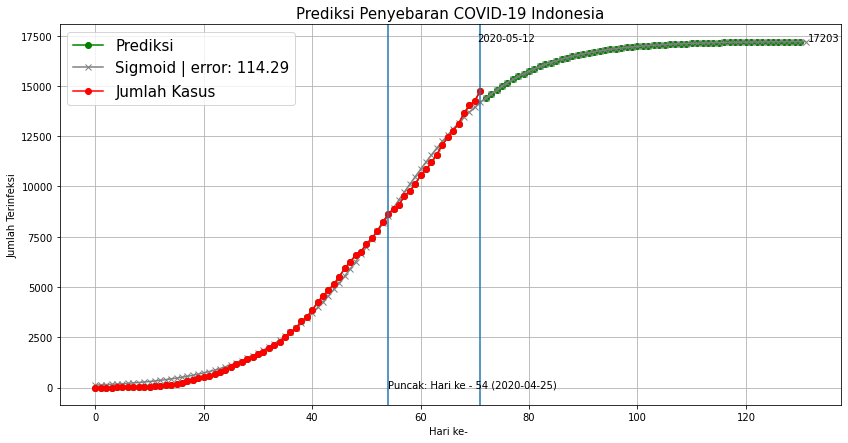

In [7]:
plot_predict("Jumlah Kasus", 60)

### Prediksi per Hari

In [0]:
def plot_predict(case, future_days):
    def avg_err(pcov):
        return np.round(np.sqrt(np.diag(pcov)).mean(), 2)

    # function to be minimized
    def f_sigmoid(x, a, b, c):
        # a = sigmoid midpoint
        # b = curve steepness (logistic growth)
        # c = max value
        return (c / (1 + np.exp(-b*(x-a))))

    day = 0    
    graph_day = data.groupby("Tanggal")[["Jumlah Kasus", "Meninggal", "Sembuh"]].sum().reset_index()[day:]    
    y = graph_day[case]
    x = np.arange(len(y))

    popt_sig, pcov_sig = curve_fit(f_sigmoid, x, y, method="dogbox", bounds=([12., 0.001, y.mean()],[90., 2.5, 10*y.max()]))
    print(popt_sig)    
    peakday = datetime.strftime(datetime.strptime(graph_day["Tanggal"][day], "%Y-%m-%d")+timedelta(days=int(popt_sig[0])), "%Y-%m-%d")
    plt.figure(figsize=(14,7))

    x_m = np.arange(len(y)+future_days)
    y_m = f_sigmoid(x_m, *popt_sig)
    
    for i in range(1,60):
        pday = datetime.strftime(datetime.strptime(graph_day["Tanggal"][day], "%Y-%m-%d")+timedelta(days=len(y)+i-1), "%Y-%m-%d")          
        plt.plot(x[-1]+i, (y_m[len(y)+i])-(y_m[len(y)+i-1]), marker="o", c="g")
    
    #plt.plot(x_m, (y_m-y_m[i-1]), c="gray", marker="x")
    plt.plot(data.aggregate("Terkonfirmasi",axis=0), marker="o", color="orange", label="Kasus per hari")            
    plt.axvline(x[-1])
    plt.text(x[-1]-.5, y_m[0], str(graph_day["Tanggal"][len(y)+day-1]), size = 10)
    plt.axvline(int(popt_sig[0]))
    plt.text(int(popt_sig[0]), 1, "Puncak: Hari ke - " + str(int(popt_sig[0])) + " (" + peakday + ")", size = 10)
    plt.xlabel("Hari ke-n")
    plt.ylabel("Terinfeksi")
    plt.title("Prediksi Penyebaran per-hari", size=15)
    plt.plot(x[-1]+i, (y_m[len(y)+i])-(y_m[len(y)+i-1]), c="g", marker="o", label="Prediksi")
    plt.legend(prop={"size": 15})
    plt.grid(zorder=0)
    plt.show

[5.41482337e+01 9.13788486e-02 1.72184568e+04]


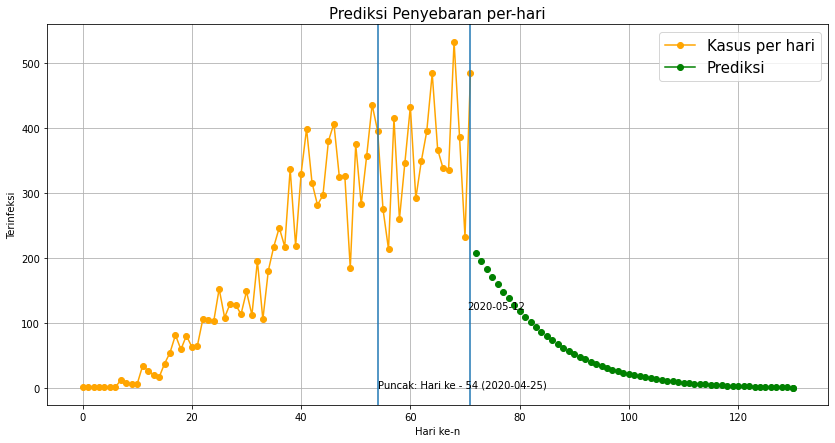

In [9]:
plot_predict("Jumlah Kasus", 60)